# PILとPIL-SIMDのjpegデコード速度比較

画像処理DNNでは、JPEGデコードやオーグメンテーションの処理時間がボトルネックになるため。

参考　[Pillow-SIMDを使った画像処理やディープラーニングの高速化の紹介 - Qiita](https://qiita.com/koshian2/items/c26656a565e42093069d)

Pillow-SIMDはwindows10だとインストールに問題が起こるので、非公式whlから入れた。

# モデルの作成・学習

## 初期化

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

fastaiのimport

In [2]:
from fastai.vision.all import *
from fastai.callback.fp16 import *    # Mixed Precisionで学習するときに必要

その他のライブラリのimport

In [3]:
from pathlib import Path
import tqdm
import json
import glob
from torchsummary import summary
import datetime  # fastai？に上書きされないように。


## データ準備

fastaiの機能でデータセット取得、約1.8GB

In [4]:
# データのルートフォルダ
img_root_path = untar_data(URLs.PETS) 

データセットのフォルダ構成確認。imagesフォルダなどがある。

In [5]:
[p.relative_to(img_root_path) for p in img_root_path.ls()]

[Path('annotations'),
 Path('crappy'),
 Path('images'),
 Path('image_gen'),
 Path('models')]

今回はimagesフォルダのデータだけ使う。

In [6]:
# 前処理前の画像のフォルダ
img_original_path = img_root_path/'images'

In [7]:
# 前処理後の画像を配置するフォルダ
img_preprocessed_path = Path('D:/bulk/dataset/image/PETS/train256')  

画像のpathへのリストを取得。画像は約7000件

In [8]:
files = get_image_files(img_original_path); len(files)

7390

# 実験

In [9]:
import time
import glob
from PIL import Image, ImageEnhance
from tqdm import tqdm

def normal_pillow():
    files = sorted(get_image_files(img_original_path))
    start_time = time.time()
    list = []
    for f in tqdm(files):
        try:
            with Image.open(f) as img:
                img = img.resize((128, 128), Image.LANCZOS)
                img = ImageEnhance.Sharpness(img).enhance(2.0)
        except:
            list.append(f)
            continue
    print("経過時間 = ", time.time()-start_time, "s")
    return list

normal_pillow();

100%|█████████████████████████████████████████████████████████████████████████████| 7390/7390 [00:12<00:00, 609.44it/s]

経過時間 =  12.128921747207642 s


📌通常のPILでPetsデータセットの画像約7000枚をリサイズ・シャープネス変換、約26.3秒

📌PIL-SIMDでPetsデータセットの画像約7000枚をリサイズ・シャープネス変換、約12.0秒

１秒当たりの変換枚数

<BarContainer object of 2 artists>

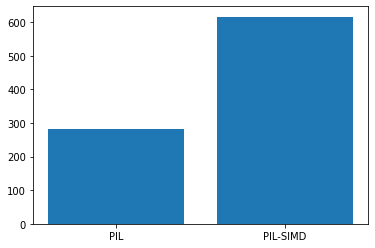

In [10]:
plt.bar(['PIL','PIL-SIMD'],[7390/26.3,7390/12])

# 実験２　デコードだけ

In [11]:
import time
import glob
from PIL import Image, ImageEnhance
from tqdm import tqdm

def normal_pillow_decode():
    files = sorted(get_image_files(img_original_path))
    start_time = time.time()
    list = []
    sizes = []
    for f in tqdm(files):
        try:
            with Image.open(f) as img:
                sizes.append(img.shape)
                # img = img.resize((128, 128), Image.LANCZOS)
                # img = ImageEnhance.Sharpness(img).enhance(2.0)
        except:
            list.append(f)
            continue
    print("経過時間 = ", time.time()-start_time, "s")
    return list

normal_pillow_decode();

100%|████████████████████████████████████████████████████████████████████████████| 7390/7390 [00:01<00:00, 5594.25it/s]

経過時間 =  1.3220009803771973 s


[]